Enter the number of rows in the grid: 5
Enter the number of columns in the grid: 5
Enter the grid layout row by row (use '.' for empty space, 'X' for obstacles, 'A' for autobot start, 'B' for goals):
Row 1: 'A', 'X', '.', 'X', 'B'
Row 2: '.', 'X', '.', '.', '.'
Row 3: '.', '.', 'X', '.', '.'
Row 4: '.', '.', '.', '.', '.'
Row 5: 'A', 'X', '.', '.', 'B'


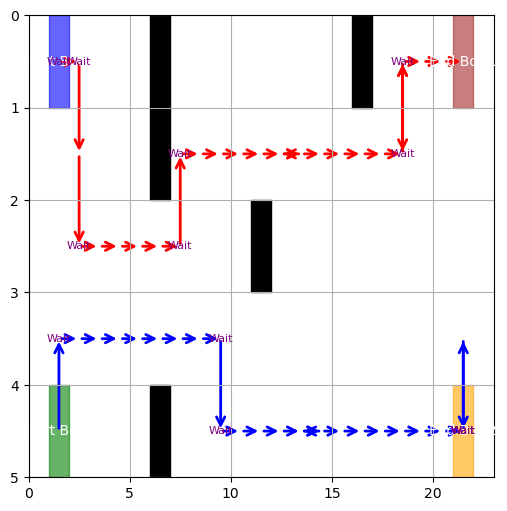


Autobot 1 Final Path: [(0, 1), (0, 1), (0, 2), (0, 2), (1, 2), (2, 2), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 7), (1, 7), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 18), (0, 18), (1, 18), (0, 18), (0, 18), (0, 19), (0, 20), (0, 21)]
Autobot 1 Actions: [2, 1, 2, 0, 0, 3, 1, 1, 1, 1, 1, 3, 0, 2, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 2, 1, 0, 1, 2, 0, 0, 0]

Autobot 2 Final Path: [(4, 1), (3, 1), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (3, 9), (4, 9), (4, 9), (4, 10), (4, 11), (4, 12), (4, 13), (4, 14), (4, 13), (4, 14), (4, 15), (4, 16), (4, 17), (4, 18), (4, 19), (4, 20), (4, 21), (4, 21), (3, 21), (4, 21), (4, 21), (4, 21), (4, 21), (4, 21), (4, 21)]
Autobot 2 Actions: [0, 2, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 2, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 0, 2, 3, 2, 3, 2]
Episode 0 - Steps taken: 2359, Time taken: 0.07 seconds
Episode 1 - Steps taken: 1306

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, FancyArrowPatch
import random
from collections import defaultdict
from queue import Queue
import time

# Warehouse environment setup with dynamic inputs
class WarehouseEnv:
    def __init__(self, grid):
        self.grid = np.array(grid)
        self.rows, self.cols = self.grid.shape
        self.autobots = []
        self.goals = []
        for r in range(self.rows):
            for c in range(self.cols):
                if self.grid[r, c] == 'A':
                    self.autobots.append((r, c, 0))  # (row, col, direction)
                elif self.grid[r, c] == 'B':
                    self.goals.append((r, c))

    def is_valid(self, pos):
        r, c = pos
        return 0 <= r < self.rows and 0 <= c < self.cols and self.grid[r, c] != 'X'

    def move(self, pos, action):
        r, c, d = pos
        if action == 0:  # Forward
            if d == 0: r -= 1
            elif d == 1: c += 1
            elif d == 2: r += 1
            else: c -= 1
        elif action == 1:  # Reverse
            if d == 0: r += 1
            elif d == 1: c -= 1
            elif d == 2: r -= 1
            else: c += 1
        elif action == 2:  # Turn Left
            d = (d - 1) % 4
        elif action == 3:  # Turn Right
            d = (d + 1) % 4
        elif action == 4:  # Wait
            pass  # Stay in place
        return (r, c, d)

    def step(self, actions):
        rewards = [0] * len(self.autobots)
        new_positions = []
        proposed_positions = []

        # First, calculate all proposed new positions
        for i, (action, autobot) in enumerate(zip(actions, self.autobots)):
            new_pos = self.move(autobot, action)
            if self.is_valid(new_pos[:2]):
                proposed_positions.append(new_pos)
            else:
                proposed_positions.append(autobot)  # Keep the old position if the move is invalid

        # Now, check for collisions
        position_count = defaultdict(int)
        for pos in proposed_positions:
            position_count[pos[:2]] += 1  # Count how many bots are proposing to move to each position

        # Finalize positions, avoiding collisions
        for i, new_pos in enumerate(proposed_positions):
            if position_count[new_pos[:2]] > 1:
                # If more than one bot is trying to move to the same position, they stay in their current positions
                new_positions.append(self.autobots[i])
                rewards[i] = -10  # Penalty for attempted collision
            else:
                # Otherwise, they can move to the new position
                new_positions.append(new_pos)
                if new_pos[:2] == self.goals[i]:
                    rewards[i] = 100  # Reward for reaching the goal
                else:
                    rewards[i] = -1  # Small penalty for moving

        self.autobots = new_positions
        done = all(autobot[:2] == goal for autobot, goal in zip(self.autobots, self.goals))
        return rewards, done

    def reset(self):
        self.autobots = [(r, c, 0) for r in range(self.rows) for c in range(self.cols) if self.grid[r, c] == 'A']


# Q-Learning agent definition
class QLearningAgent:
    def __init__(self, action_size, learning_rate=0.1, discount_factor=0.95, epsilon=0.1):
        self.q_table = defaultdict(lambda: np.zeros(action_size))
        self.lr = learning_rate
        self.gamma = discount_factor
        self.epsilon = epsilon
        self.action_size = action_size

    def get_action(self, state):
        if random.random() < self.epsilon:
            return random.randint(0, self.action_size - 1)
        else:
            return np.argmax(self.q_table[state])

    def update(self, state, action, reward, next_state):
        current_q = self.q_table[state][action]
        next_max_q = np.max(self.q_table[next_state])
        new_q = current_q + self.lr * (reward + self.gamma * next_max_q - current_q)
        self.q_table[state][action] = new_q


# Train the agents in the environment
def train(env, agents, episodes=1000):
    time_taken = []
    final_paths = [[] for _ in range(len(env.autobots))]  # To store the final paths for each bot
    all_actions = [[] for _ in range(len(env.autobots))]  # To store actions for each bot

    for episode in range(episodes):
        done = False
        steps = 0
        start_time = time.time()

        # Reset the environment and paths
        env.reset()
        paths = [[autobot[:2]] for autobot in env.autobots]  # Store initial positions
        episode_actions = [[] for _ in range(len(env.autobots))]  # Store actions taken in each episode

        while not done:
            states = [tuple(autobot) for autobot in env.autobots]
            actions = [agent.get_action(state) for agent, state in zip(agents, states)]
            rewards, done = env.step(actions)

            # Update paths and actions for each autobot
            for i, (autobot, action) in enumerate(zip(env.autobots, actions)):
                paths[i].append(autobot[:2])  # Add new position to the path
                episode_actions[i].append(action)  # Record the action taken
                agents[i].update(states[i], action, rewards[i], tuple(autobot))

            steps += 1

        end_time = time.time()
        time_taken.append((episode, steps, end_time - start_time))

        # Store the final paths and actions for this episode
        if episode == episodes - 1:  # Save only the final episode data
            final_paths = paths
            all_actions = episode_actions

    return final_paths, all_actions, time_taken


# Visualization function for paths with arrows
def visualize_path_with_arrows(env, paths):
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set_xlim(0, env.cols)
    ax.set_ylim(0, env.rows)
    ax.invert_yaxis()

    # Color map for paths
    path_colors = ['red', 'blue']

    # Draw grid, obstacles, start and end points
    for r in range(env.rows):
        for c in range(env.cols):
            if env.grid[r, c] == 'X':  # Obstacle
                ax.add_patch(Rectangle((c, r), 1, 1, color='black'))
            elif env.grid[r, c] == 'A':  # Start points for bots
                if (r, c) == paths[0][0]:
                    ax.add_patch(Rectangle((c, r), 1, 1, color='blue', alpha=0.6))
                    ax.text(c + 0.5, r + 0.5, 'Start Bot 1', color='white', ha='center', va='center')
                elif (r, c) == paths[1][0]:
                    ax.add_patch(Rectangle((c, r), 1, 1, color='green', alpha=0.6))
                    ax.text(c + 0.5, r + 0.5, 'Start Bot 2', color='white', ha='center', va='center')
            elif env.grid[r, c] == 'B':  # End points for bots
                if (r, c) == paths[0][-1]:
                    ax.add_patch(Rectangle((c, r), 1, 1, color='brown', alpha=0.6))
                    ax.text(c + 0.5, r + 0.5, 'End Bot 1', color='white', ha='center', va='center')
                elif (r, c) == paths[1][-1]:
                    ax.add_patch(Rectangle((c, r), 1, 1, color='orange', alpha=0.6))
                    ax.text(c + 0.5, r + 0.5, 'End Bot 2', color='white', ha='center', va='center')

    # Draw paths with arrows
    for i, path in enumerate(paths):
        color = path_colors[i]
        for j in range(len(path) - 1):
            start = path[j]
            end = path[j + 1]
            if start == end:
                ax.text(start[1] + 0.5, start[0] + 0.5, 'Wait', color='purple', ha='center', va='center', fontsize=8)
            else:
                ax.add_patch(FancyArrowPatch((start[1] + 0.5, start[0] + 0.5), (end[1] + 0.5, end[0] + 0.5), 
                                             color=color, arrowstyle='->', mutation_scale=15, lw=2))

    plt.grid(True)
    plt.show()


# Get dynamic inputs from the user
def get_dynamic_grid_input():
    rows = int(input("Enter the number of rows in the grid: "))
    cols = int(input("Enter the number of columns in the grid: "))
    print("Enter the grid layout row by row (use '.' for empty space, 'X' for obstacles, 'A' for autobot start, 'B' for goals):")
    
    grid = []
    for r in range(rows):
        row = input(f"Row {r + 1}: ")
        grid.append(list(row))

    return grid


# Main function with dynamic grid input
def main():
    # Get dynamic grid input from user
    grid = get_dynamic_grid_input()
    env = WarehouseEnv(grid)
    agents = [QLearningAgent(action_size=5) for _ in range(len(env.autobots))]  # Add 'wait' as an action

    # Train and get paths, actions & time taken
    final_paths, final_actions, time_taken = train(env, agents, episodes=1000)

    # Visualize final paths
    visualize_path_with_arrows(env, final_paths)

    # Print out the final paths and actions taken
    for i in range(len(final_paths)):
        print(f"\nAutobot {i + 1} Final Path: {final_paths[i]}")
        print(f"Autobot {i + 1} Actions: {final_actions[i]}")

    # Print out the time taken by bots to reach their goals
    for episode, steps, duration in time_taken:
        print(f"Episode {episode} - Steps taken: {steps}, Time taken: {duration:.2f} seconds")


if __name__ == "__main__":
    main()


In [13]:
def evaluate(env, agents, episodes=100):
    success_count = 0
    for episode in range(episodes):
        env.reset()
        done = False
        while not done:
            states = tuple(autobot for autobot in env.autobots)
            actions = [agent.get_action(state) for agent, state in zip(agents, states)]
            _, done = env.step(actions)
        
        # Check if all autobots have reached their respective goals
        if all(autobot[:2] == goal for autobot, goal in zip(env.autobots, env.goals)):
            success_count += 1

    success_rate = success_count / episodes * 100
    print(f"Success Rate over {episodes} episodes: {success_rate:.2f}%")

# Example usage
evaluate(env, agents, episodes=1000)

Success Rate over 1000 episodes: 100.00%
